index: Index(['positive', 'negative'], dtype='object', name='Sentiment')
values: [200 200]
all_values: 400


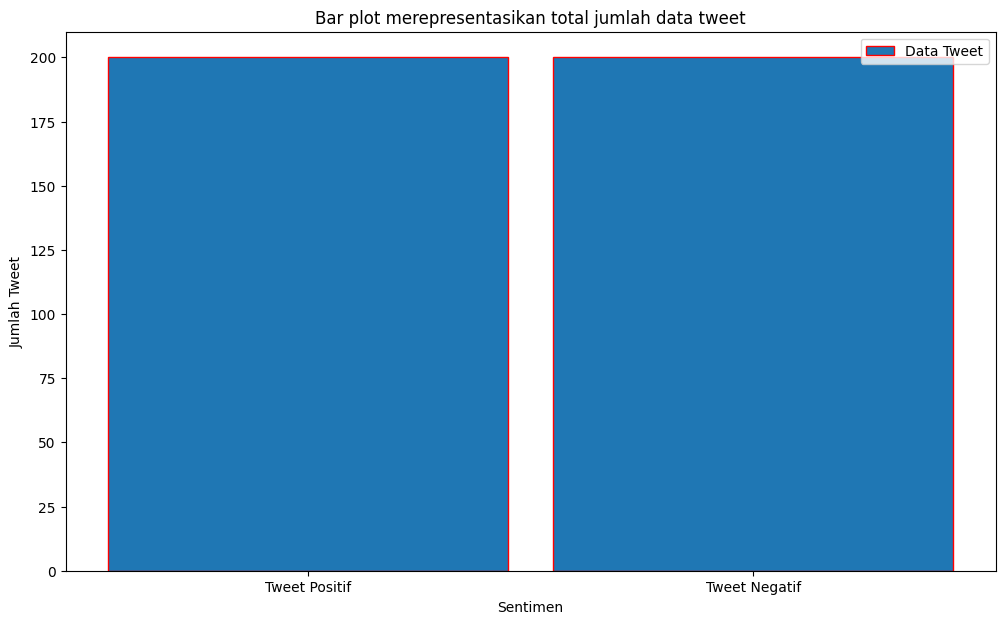

Multinomial Naive Bayes:
Mean Accuracy: 0.7825000000000001
Mean Precision: 0.7722212792367591
Mean Recall: 0.82
Bernouilli Naive Bayes:
Mean Accuracy: 0.7575000000000001
Mean Precision: 0.7052715517325319
Mean Recall: 0.925
Gaussian Naive Bayes:
Mean Accuracy: 0.7150000000000001
Mean Precision: 0.6680199784112827
Mean Recall: 0.86


In [33]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Load data
df = pd.read_csv('text_preprocessing/final_dataset.csv')

# Visualize data
tweet_bar_df = df['Sentiment'].value_counts()
print(f'index: {tweet_bar_df.index}')
print(f'values: {tweet_bar_df.values}')
print(f'all_values: {tweet_bar_df.sum()}')

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
sentimen = ['Tweet Positif', 'Tweet Negatif']
plt.bar(sentimen, tweet_bar_df.values, align='center', edgecolor='red', width=0.9)
i = 1.0
j = 30
for i in range(len(sentimen)):
    plt.annotate(tweet_bar_df.values[i], (-0.1 + i, tweet_bar_df.values[i] + j))
plt.legend(labels=['Data Tweet'])
plt.title("Bar plot merepresentasikan total jumlah data tweet")
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Tweet')
plt.show()

# Konversi sentimen positif = 1 negatif = 0
def convert_label_sentimen(label_sentimen):
    return 1 if label_sentimen == "positive" else 0

df['label_sentimen'] = df['Sentiment'].apply(convert_label_sentimen)
df.drop(df.columns[[0]], axis=1, inplace=True)

X = df['tweet_tokens_stemmed']
y = df['label_sentimen']

# K-fold cross validation (splitting data)
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Function to perform PSO feature selection
def pso_feature_selection(X_train, y_train, n_particles, n_iterations, num_features):
    num_samples, num_features = X_train.shape
    bounds = [0, 1]  # Assuming the feature selection is binary (selected or not)
    inertia = 0.8
    cognitive_weight = 1.5
    social_weight = 1.5

    # Initialize PSO
    num_particles = n_particles
    dimensions = num_features
    particles = np.random.rand(num_particles, dimensions)
    velocities = np.random.rand(num_particles, dimensions)
    best_positions = particles.copy()
    best_scores = np.zeros(num_particles)

    global_best_position = np.zeros(dimensions)
    global_best_score = 0

    for iteration in range(n_iterations):
        for particle in range(num_particles):
            # Evaluate fitness (accuracy) of current particle
            selected_features = particles[particle] > 0.5
            accuracy = evaluate_features(X_train, y_train, selected_features)

            # Update particle's best position and score
            if accuracy > best_scores[particle]:
                best_scores[particle] = accuracy
                best_positions[particle] = particles[particle].copy()

            # Update global best position and score
            if accuracy > global_best_score:
                global_best_score = accuracy
                global_best_position = particles[particle].copy()

            # Update particle's velocity
            r1 = np.random.rand(dimensions)
            r2 = np.random.rand(dimensions)
            velocities[particle] = (inertia * velocities[particle] +
                                   cognitive_weight * r1 * (best_positions[particle] - particles[particle]) +
                                   social_weight * r2 * (global_best_position - particles[particle]))

            # Update particle's position
            particles[particle] += velocities[particle]
            particles[particle] = np.clip(particles[particle], bounds[0], bounds[1])

    return global_best_position > 0.5

# Function to evaluate features using selected features and classifier
def evaluate_features(X_train, y_train, selected_features):
    X_selected = X_train[:, selected_features]
    clf = MultinomialNB()  # You can change the classifier here if needed
    cv_results = cross_val_score(clf, X_selected, y_train, cv=kfold, scoring='accuracy')
    return cv_results.mean()

# MULTINOMIAL NAIVE BAYES
cv_accuracy_mnb = []
cv_precision_mnb = []
cv_recall_mnb = []

for train_idx, test_idx in kfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # TF-IDF Vectorization
    tfidf_model = TfidfVectorizer(smooth_idf=False).fit(X_train)
    X_train_tfidf = tfidf_model.transform(X_train).toarray()
    X_test_tfidf = tfidf_model.transform(X_test).toarray()

    # Feature Selection using PSO
    selected_features = pso_feature_selection(X_train_tfidf, y_train, n_particles=10, n_iterations=100, num_features=num_features)

    # Train model using selected features
    mnb = MultinomialNB()
    mnb.fit(X_train_tfidf[:, selected_features], y_train)

    # Predictions
    predict_mnb = mnb.predict(X_test_tfidf[:, selected_features])

    # Evaluation
    accuracy_mnb = accuracy_score(y_test, predict_mnb)
    precision_mnb = precision_score(y_test, predict_mnb)
    recall_mnb = recall_score(y_test, predict_mnb)

    cv_accuracy_mnb.append(accuracy_mnb)
    cv_precision_mnb.append(precision_mnb)
    cv_recall_mnb.append(recall_mnb)

# Calculate average scores for Multinomial Naive Bayes
mean_accuracy_mnb = np.mean(cv_accuracy_mnb)
mean_precision_mnb = np.mean(cv_precision_mnb)
mean_recall_mnb = np.mean(cv_recall_mnb)

print("Multinomial Naive Bayes:")
print("Mean Accuracy:", mean_accuracy_mnb)
print("Mean Precision:", mean_precision_mnb)
print("Mean Recall:", mean_recall_mnb)

# BURNOUILLI NAIVE BAYES
cv_accuracy_bnb = []
cv_precision_bnb = []
cv_recall_bnb = []

for train_idx, test_idx in kfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # TF-IDF Vectorization
    tfidf_model = TfidfVectorizer(smooth_idf=False).fit(X_train)
    X_train_tfidf = tfidf_model.transform(X_train).toarray()
    X_test_tfidf = tfidf_model.transform(X_test).toarray()

    # Feature Selection using PSO
    selected_features = pso_feature_selection(X_train_tfidf, y_train, n_particles=10, n_iterations=100, num_features=num_features)

    # Train model using selected features
    bnb = BernoulliNB()
    bnb.fit(X_train_tfidf[:, selected_features], y_train)

    # Predictions
    predict_bnb = bnb.predict(X_test_tfidf[:, selected_features])

    # Evaluation
    accuracy_bnb = accuracy_score(y_test, predict_bnb)
    precision_bnb = precision_score(y_test, predict_bnb)
    recall_bnb = recall_score(y_test, predict_bnb)

    cv_accuracy_bnb.append(accuracy_bnb)
    cv_precision_bnb.append(precision_bnb)
    cv_recall_bnb.append(recall_bnb)

# Calculate average scores for Bernouilli Naive Bayes
mean_accuracy_bnb = np.mean(cv_accuracy_bnb)
mean_precision_bnb = np.mean(cv_precision_bnb)
mean_recall_bnb = np.mean(cv_recall_bnb)

print("Bernouilli Naive Bayes:")
print("Mean Accuracy:", mean_accuracy_bnb)
print("Mean Precision:", mean_precision_bnb)
print("Mean Recall:", mean_recall_bnb)

# GAUSSIAN NAIVE BAYES
cv_accuracy_gnb = []
cv_precision_gnb = []
cv_recall_gnb = []

for train_idx, test_idx in kfold.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # TF-IDF Vectorization
    tfidf_model = TfidfVectorizer(smooth_idf=False).fit(X_train)
    X_train_tfidf = tfidf_model.transform(X_train).toarray()
    X_test_tfidf = tfidf_model.transform(X_test).toarray()

    # Feature Selection using PSO
    selected_features = pso_feature_selection(X_train_tfidf, y_train, n_particles=10, n_iterations=100, num_features=num_features)

    # Train model using selected features
    gnb = GaussianNB()
    gnb.fit(X_train_tfidf[:, selected_features], y_train)

    # Predictions
    predict_gnb = gnb.predict(X_test_tfidf[:, selected_features])

    # Evaluation
    accuracy_gnb = accuracy_score(y_test, predict_gnb)
    precision_gnb = precision_score(y_test, predict_gnb)
    recall_gnb = recall_score(y_test, predict_gnb)

    cv_accuracy_gnb.append(accuracy_gnb)
    cv_precision_gnb.append(precision_gnb)
    cv_recall_gnb.append(recall_gnb)

# Calculate average scores for Bernouilli Naive Bayes
mean_accuracy_gnb = np.mean(cv_accuracy_gnb)
mean_precision_gnb = np.mean(cv_precision_gnb)
mean_recall_gnb = np.mean(cv_recall_gnb)

print("Gaussian Naive Bayes:")
print("Mean Accuracy:", mean_accuracy_gnb)
print("Mean Precision:", mean_precision_gnb)
print("Mean Recall:", mean_recall_gnb)